In [5]:
import pandas as pd
import os
import utils
import consts
import numpy as np
from importlib import reload
import hypoxia_index as hi
import matplotlib.pyplot as plt
import seaborn as sns
import statannot
from scipy import stats
from utils import make_per_dataset_df, make_coord_plots

reload(utils)
reload(consts)
reload(hi)
PATH = os.getcwd()

In [8]:
# Load the aggregated dataframes that are generated by the code written in 'integ_rna_seq_analysis.ipynb'
results_df = pd.read_parquet(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results.parquet.gzip'), engine = 'pyarrow').rename(columns = {'Name' : 'gene'})

sample_data = pd.read_parquet(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined', 'combined_sample_data.parquet.gzip'),engine = 'pyarrow')
for Complex in ['I', 'II', 'III', 'IV', 'V']:
    results_df.loc[(results_df['Complex'] == Complex) & (results_df['Protein_type'] == 'Assembly'), 'Complex'] = Complex + 'a'

# Replace PC with PC3 in all 'cell_line' columns

results_df = results_df.replace('PC', 'PC3')

# Load Supplementary Table 1 excel
supp_table = pd.read_excel(os.path.join(PATH, 'data', 'dataset_summary.xlsx'), sheet_name = 'Supplementary Table S1')
results_df = results_df.merge(supp_table, left_on = 'dataset', right_on = 'Dataset name', how = 'left')
results_df['Oxygen Concentration'] = results_df['Oxygen Concentration'] * 100

# Save results_df as a csv file
results_df.to_csv(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results.csv'), index = False)

In [9]:
supp_table[supp_table['Cell line'] == 'HeLa']

,Dataset name,Project Accs,Cell line,Source Tissue,Cancer,Oxygen Concentration,Time(hr),Control N,Treatment N,Total,Confirmed,Link
6,HeLa_hypx_2,PRJNA494075,HeLa,Epithelial cells,Adenocarcinoma,0.01,16,3,3,6,v,NaN
15,HeLa_hypx_3,PRJNA773654,HeLa,Epithelial cells,Adenocarcinoma,0.01,24,3,3,6,v,https://www.ncbi.nlm.nih.gov/bioproject/PRJNA7...


In [10]:
# Which sample is in supp_table['Dataset name'] but not in results_df['dataset']?
missing_samples = results_df[~results_df['dataset'].isin(supp_table['Dataset name'])]
if not missing_samples.empty:
    print("Missing samples in results_df:")
    print(missing_samples)

Missing samples in results_df:
                  gene     baseMean  log2FoldChange     lfcSE      stat  \
476190          TSPAN6  4415.243983       -0.512538  0.056616 -9.052843   
476191            DPM1  3799.918020       -0.234138  0.063209 -3.704176   
476192           SCYL3  1316.742918       -0.054374  0.078310 -0.694341   
476193        C1ORF112   985.335253       -0.624262  0.090625 -6.888394   
476194             CFH     6.406705        0.981437  1.097605  0.894162   
...                ...          ...             ...       ...       ...   
660634    RP11-793J2.1     7.329248       -0.640422  0.450132 -1.422743   
660635   RP11-419I17.1     4.463906        0.489867  0.569054  0.860845   
660636    RP11-434E6.5    25.460432        0.246752  0.321606  0.767248   
660637  RP11-122G18.12    35.913344       -0.036630  0.236635 -0.154797   
660638    RP5-937E21.8     3.549076       -0.652177  0.639211 -1.020285   

              pvalue          padj     dataset cell_line Complex  ..

In [12]:
# Split into 1% datasets and lower oxygen concentration datasets
results_df_1 = results_df[results_df['Oxygen Concentration'] == 1]
results_df_low = results_df[results_df['Oxygen Concentration'] < 1]
# Generate summaries of the number of samples, datasets and cell types represented
print(f"{len(results_df.dataset.unique())} different datasets\nBelonging to {len(results_df.cell_line.unique())} different cells with an average of {results_df.groupby('cell_line').agg({'dataset' : 'nunique'}).mean()}+- {results_df.groupby('cell_line').agg({'dataset' : 'nunique'}).std()} datasets per cell")
# Print the number of datasets and samples in the 1% and lower oxygen concentration datasets
print(f"\n1% oxygen concentration datasets: {len(results_df_1.dataset.unique())} datasets with {len(results_df_1)} samples\nLower oxygen concentration datasets: {len(results_df_low.dataset.unique())} datasets with {len(results_df_low)} samples")


29 different datasets
Belonging to 21 different cells with an average of dataset    1.380952
dtype: float64+- dataset    0.740013
dtype: float64 datasets per cell

1% oxygen concentration datasets: 15 datasets with 365944 samples
Lower oxygen concentration datasets: 9 datasets with 198362 samples


In [13]:
# Look at the expression of qpcr genes
results_df_matrix_u87 = results_df[results_df['cell_line'].isin(['U87', 'HEB'])].drop_duplicates(subset = ['gene', 'dataset']).pivot(index = 'gene', columns = 'dataset', values = 'log2FoldChange').dropna()
results_df_matrix_u87['mean'] = results_df_matrix_u87.mean(axis = 1)
results_df_matrix_u87 = results_df_matrix_u87
results_df_matrix_u87.loc[['NDUFA12', 'NDUFAB1', 'SDHB', 'UQCRB', 'COX7B',  'ACTB', 'GAPDH', 'MT-CO1', 'MT-CO3', 'MT-ND5', 'RRP1', 'MXI1', 'NDRG1', 'ANGPTL4', 'ANKRD37']].sort_values(by = 'mean', ascending = True)

dataset,U87_local,mean
gene,,
RRP1,-0.250679,-0.250679
NDUFAB1,-0.161801,-0.161801
SDHB,-0.096234,-0.096234
COX7B,-0.082832,-0.082832
NDUFA12,-0.044194,-0.044194
UQCRB,-0.031776,-0.031776
MT-CO1,0.090233,0.090233
MT-CO3,0.145930,0.145930
ACTB,0.188004,0.188004


In [14]:
# Drop U87_hypx_1, U87_hypx_2, HEB_hypx_1 and HEB_hypx_2 because the similarity between replicative datasets is way too high
results_df = results_df[~results_df['dataset'].isin(['U87_hypx_1', 'U87_hypx_2', 'HEB_hypx_1', 'HEB_hypx_2'])]
# Drop unnecessary cell lines SMC and MDA
results_df = results_df[~results_df['cell_line'].isin(['SMC'])]


In [15]:
# Generate a separate summary dataset dataframe. This dataframe will be used to generate the summary statistics for the datasets
datasets = results_df.dataset.unique().tolist()
results_df['tfam_lfc'] = 0
results_df['oxphos_lfc'] = 0
results_df['ribos_lfc'] = 0
for dataset in results_df.dataset.unique().tolist():
    results_df.loc[results_df.dataset == dataset, 'tfam_lfc'] = results_df[(results_df.gene == 'TFAM') & (results_df['dataset'] == dataset)].iloc[0]['log2FoldChange']
    results_df.loc[results_df.dataset == dataset, 'oxphos_lfc'] = results_df[(results_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['dataset'] == dataset)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_lfc'] = results_df[(results_df.Complex == 'Ribosome') & (results_df['dataset'] == dataset)]['log2FoldChange'].mean()


C:\Users\shtolz\AppData\Local\Temp\ipykernel_37884\2976560695.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.397948108725142' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_df.loc[results_df.dataset == dataset, 'tfam_lfc'] = results_df[(results_df.gene == 'TFAM') & (results_df['dataset'] == dataset)].iloc[0]['log2FoldChange']
C:\Users\shtolz\AppData\Local\Temp\ipykernel_37884\2976560695.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.21899256203240575' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  results_df.loc[results_df.dataset == dataset, 'oxphos_lfc'] = results_df[(results_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['dataset'] == dataset)]['log2FoldChange'].mean()
C:\Users\shtolz\AppData\Local\

In [16]:
# Split assembly and structural genes.

NUC_OXPHOS_GENES = results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'NUC')].gene.unique().tolist()
MT_OXPHOS_GENES = results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'MT')].gene.unique().tolist()
COMPLEX_1_GENES = results_df[(results_df['Complex'] == 'I')].gene.unique().tolist()
COMPLEX_2_GENES = results_df[(results_df['Complex'] == 'II')].gene.unique().tolist()
COMPLEX_3_GENES = results_df[(results_df['Complex'] == 'III')].gene.unique().tolist()
COMPLEX_4_GENES = results_df[(results_df['Complex'] == 'IV')].gene.unique().tolist()
COMPLEX_5_GENES = results_df[(results_df['Complex'] == 'V')].gene.unique().tolist()

NUC_RIBOSOME_GENES = results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'NUC')].gene.unique().tolist()
MT_RIBOSOME_GENES = results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'MT')].gene.unique().tolist()
N_NUC_OXPHOS_GENES = len(NUC_OXPHOS_GENES)
N_MT_OXPHOS_GENES = len(MT_OXPHOS_GENES)
N_NUC_RIBOSOME_GENES = len(NUC_RIBOSOME_GENES)
N_MT_RIBOSOME_GENES = len(MT_RIBOSOME_GENES)

# Print all lists
print('NUC_OXPHOS_GENES: ', N_NUC_OXPHOS_GENES)
print('MT_OXPHOS_GENES: ', N_MT_OXPHOS_GENES)
print('################################')
print('COMPLEX_1_GENES: ', len(COMPLEX_1_GENES))
print('COMPLEX_2_GENES: ', len(COMPLEX_2_GENES))
print('COMPLEX_3_GENES: ', len(COMPLEX_3_GENES))
print('COMPLEX_4_GENES: ', len(COMPLEX_4_GENES))
print('COMPLEX_5_GENES: ', len(COMPLEX_5_GENES))
print('################################')
print('NUC_RIBOSOME_GENES: ', N_NUC_RIBOSOME_GENES)
print('MT_RIBOSOME_GENES: ', N_MT_RIBOSOME_GENES)

NUC_OXPHOS_GENES:  88
MT_OXPHOS_GENES:  13
################################
COMPLEX_1_GENES:  44
COMPLEX_2_GENES:  4
COMPLEX_3_GENES:  11
COMPLEX_4_GENES:  22
COMPLEX_5_GENES:  21
################################
NUC_RIBOSOME_GENES:  78
MT_RIBOSOME_GENES:  2


In [20]:
# Calculate the average number of genes that are significantly differentially expressed in hypoxia
frac_sign = results_df[results_df['padj'] < .05].groupby('dataset').agg({'gene' : 'nunique'}).mean()/results_df.groupby('dataset').agg({'gene' : 'nunique'}).mean()

In [22]:
# Create a list of coordinated, uncoordinated and unassigned using the mitonuclear coordination function for OXPHOS genes
coord, uncoord, unassigned, coord_dict, nuc_dict, mt_dict = utils.mitonuclear_coordination(results_df, nuc_gene_thresh = round(N_NUC_OXPHOS_GENES * 0.25), mt_gene_thresh = round(N_MT_OXPHOS_GENES * .25), padj_thresh = .1, genes = 'OXPHOS', lfc_col = 'log2FoldChange')
# Add the coordination column to results_df and counts_comb
results_df['oxphos_coordination'] = results_df.dataset.apply(lambda x: 'Coordinated' if x in coord else 'Uncoordinated' if x in uncoord else 'Unassigned')


results_df['oxphos_coordination_value'] = results_df.dataset.apply(lambda x: coord_dict[x] if x in coord_dict.keys() else np.nan)
results_df['oxphos_nuclear_value'] = results_df.dataset.apply(lambda x: nuc_dict[x] if x in nuc_dict.keys() else np.nan)
results_df['oxphos_mitochondrial_value'] = results_df.dataset.apply(lambda x: mt_dict[x] if x in mt_dict.keys() else np.nan)

print(f'Out of {len(results_df.cell_line.unique())} cell lines, {len(results_df[(results_df.oxphos_coordination == "Coordinated")].cell_line.unique())} are coordinated, {len(results_df[(results_df.oxphos_coordination == "Uncoordinated")].cell_line.unique())} are uncoordinated and {len(results_df[(results_df.oxphos_coordination == "Unassigned")].cell_line.unique())} are unassigned')

Not enough OXPHOS genes in A549_hypx_0 (MT: 1, NUC: 2). Skipping...
Not enough OXPHOS genes in A549_hypx_1 (MT: 6, NUC: 4). Skipping...
Not enough OXPHOS genes in HPMEC_hypx_1 (MT: 10, NUC: 15). Skipping...
Not enough OXPHOS genes in HUVEC_rna_hypx (MT: 4, NUC: 11). Skipping...
Not enough OXPHOS genes in MCF7_local (MT: 11, NUC: 11). Skipping...
Not enough OXPHOS genes in MDA_231_hypx_1 (MT: 0, NUC: 24). Skipping...
Not enough OXPHOS genes in PC3_hypx_0 (MT: 0, NUC: 29). Skipping...
Not enough OXPHOS genes in RCC4_hypx_1 (MT: 6, NUC: 13). Skipping...
Not enough OXPHOS genes in U87_local (MT: 0, NUC: 6). Skipping...
Out of 26 datasets, 9 datasets were skipped due to insufficient genes.
13 datasets were coordinated, and 4 datasets were uncoordinated.
The magnitude of coordination was 0.11 +- 0.15
Out of 20 cell lines, 10 are coordinated, 4 are uncoordinated and 10 are unassigned


In [23]:
results_df = results_df.sort_values('oxphos_coordination_value', ascending = False)
results_df.groupby('dataset').agg({'oxphos_coordination': 'first', 'oxphos_coordination_value' : 'mean', 'oxphos_nuclear_value' :'mean', 'oxphos_mitochondrial_value' : 'mean'}).sort_values('oxphos_coordination_value', ascending = False).head(10)

,oxphos_coordination,oxphos_coordination_value,oxphos_nuclear_value,oxphos_mitochondrial_value
dataset,,,,
T_hypx_1,Coordinated,0.515734,0.670455,0.769231
LNCaP_hypx_1,Coordinated,0.329545,0.329545,1.000000
MCF7_hypx_2,Coordinated,0.325175,0.352273,0.923077
RKO_hypx_1,Coordinated,0.288462,0.340909,0.846154
RPE_hypx_1,Coordinated,0.261364,0.261364,1.000000
HepG2_hypx_0,Coordinated,0.228147,0.329545,0.692308
MCF7_hypx_1,Coordinated,0.226399,0.420455,0.538462
H460_hypx_1,Coordinated,0.220280,0.238636,0.923077
HCT-116_hypx_0,Coordinated,0.201049,0.522727,0.384615


In [25]:
# Create a list of coordinated, uncoordinated and unassigned using the mitonuclear coordination function for OXPHOS genes
ribo_coord, ribo_uncoord, ribo_unassigned, ribo_coord_dict, ribo_nuc_dict, ribo_mt_dict = utils.mitonuclear_coordination(results_df, nuc_gene_thresh = N_NUC_RIBOSOME_GENES * .25, mt_gene_thresh = 2, padj_thresh = .1, genes = 'Ribosome', lfc_col = 'log2FoldChange')
# Add the coordination column to results_df and counts_comb
results_df['ribosome_coordination'] = results_df.dataset.apply(lambda x: 'Coordinated' if x in ribo_coord else 'Uncoordinated' if x in ribo_uncoord else 'Unassigned')
results_df['ribosome_coordination_value'] = results_df.dataset.apply(lambda x: ribo_coord_dict[x] if x in ribo_coord_dict.keys() else np.nan)
results_df['ribosome_nuclear_value'] = results_df.dataset.apply(lambda x: ribo_nuc_dict[x] if x in ribo_nuc_dict.keys() else np.nan)
results_df['ribosome_mitochondrial_value'] = results_df.dataset.apply(lambda x: ribo_mt_dict[x] if x in ribo_mt_dict.keys() else np.nan)
by_dataset = results_df.groupby('dataset').agg({'oxphos_coordination' : 'first', 'ribosome_coordination' : 'first', 'cell_line': 'first'})
print(f'Out of {len(results_df.cell_line.unique())} cell lines, {len(results_df[(results_df.ribosome_coordination == "Coordinated")].cell_line.unique())} are coordinated, {len(results_df[(results_df.ribosome_coordination == "Uncoordinated")].cell_line.unique())} are uncoordinated and {len(results_df[(results_df.ribosome_coordination == "Unassigned")].cell_line.unique())} are unassigned')

Not enough Ribosome genes in MCF7_hypx_2 (MT: 1, NUC: 61). Skipping...
Not enough Ribosome genes in RPE_hypx_1 (MT: 0, NUC: 34). Skipping...
Not enough Ribosome genes in HepG2_hypx_0 (MT: 1, NUC: 49). Skipping...
Not enough Ribosome genes in MCF7_hypx_1 (MT: 1, NUC: 61). Skipping...
Not enough Ribosome genes in H460_hypx_1 (MT: 1, NUC: 53). Skipping...
Not enough Ribosome genes in HCT-116_hypx_0 (MT: 0, NUC: 43). Skipping...
Not enough Ribosome genes in MCF7_local (MT: 0, NUC: 29). Skipping...
Not enough Ribosome genes in RCC4_hypx_1 (MT: 0, NUC: 22). Skipping...
Not enough Ribosome genes in HCT-116_local (MT: 1, NUC: 64). Skipping...
Not enough Ribosome genes in HCT-116_hypx_2 (MT: 0, NUC: 55). Skipping...
Not enough Ribosome genes in HUVEC_rna_hypx (MT: 1, NUC: 22). Skipping...
Not enough Ribosome genes in A549_hypx_1 (MT: 0, NUC: 2). Skipping...
Not enough Ribosome genes in U87_local (MT: 1, NUC: 19). Skipping...
Not enough Ribosome genes in MDA_231_hypx_1 (MT: 1, NUC: 33). Skipping

In [26]:
# The proportion of datasets per cell line that are coordinated
by_dataset['ribosome_concordance'] = by_dataset.apply(lambda x : len(by_dataset[(by_dataset['cell_line'] == x['cell_line']) & (by_dataset['ribosome_coordination'] == x['ribosome_coordination'])]) / len(by_dataset[(by_dataset['cell_line'] == x['cell_line'])]) * 100, axis = 1)
by_dataset['oxphos_concordance'] = by_dataset.apply(lambda x : len(by_dataset[(by_dataset['cell_line'] == x['cell_line']) & (by_dataset['oxphos_coordination'] == x['oxphos_coordination'])]) / len(by_dataset[(by_dataset['cell_line'] == x['cell_line'])]) * 100, axis = 1)

In [27]:
count_dict = {i:1 for i in results_df.cell_line.unique()}
# Change the dataset names to include the cell type underscore index number 
results_df['dataset_short'] = results_df.dataset
for dataset in results_df.dataset.unique():
    cell_type = results_df[results_df.dataset == dataset].cell_line.unique()[0]
    name = cell_type + ' ' + str(count_dict[cell_type]) if count_dict[cell_type] > 1 else cell_type
    count_dict[cell_type] += 1
    results_df.loc[results_df['dataset_short'] == dataset, 'dataset_short'] = name
    results_df.loc[results_df['dataset_short'] == dataset, 'dataset_short'] = name

In [23]:
weights = hi.generate_hypx_weights(topN = 5)

In [30]:
# Generate Lombardi et al. hypoxia weights
with open(os.path.join(PATH, 'data', 'genes', 'Lombardi_hyp_genes.txt')) as f:
    lombardi_gene_list = f.read().splitlines()
lombardi_weights = hi.generate_hypx_weights(topN = len(lombardi_gene_list), hypx_sorted_list = lombardi_gene_list)


In [34]:
# Calculate the hypx scores for each dataset and all weight types

dataset = results_df.dataset.unique()
results_df['hindex'] = np.nan
results_df['lombardi_hindex'] = np.nan
results_df['tfam_lfc'] = np.nan
for dataset in dataset:
    dataset_df = results_df[results_df.dataset == dataset]
    lombardi_hindex = hi.hypx_index(dataset_df, lombardi_weights, gene_col = 'gene')
    results_df.loc[results_df.dataset == dataset, 'lombardi_hindex'] = lombardi_hindex
    results_df.loc[results_df.dataset == dataset, 'tfam_lfc'] = dataset_df[dataset_df.gene == 'TFAM'].iloc[0]['log2FoldChange']
    results_df.loc[results_df.dataset == dataset, 'oxphos_lfc'] = dataset_df[(dataset_df.Complex.isin(['I', 'II', 'III', 'IV', 'V']))]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_lfc'] = dataset_df[(dataset_df.Complex == 'Ribosome')]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'oxphos_nuc_lfc'] = dataset_df[(dataset_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (dataset_df.Genome == 'NUC') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'oxphos_mt_lfc'] = dataset_df[(dataset_df.Complex.isin(['I', 'II', 'III', 'IV', 'V'])) & (dataset_df.Genome == 'MT') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_nuc_lfc'] = dataset_df[(dataset_df.Complex == 'Ribosome') & (dataset_df.Genome == 'NUC') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'ribos_mt_lfc'] = dataset_df[(dataset_df.Complex == 'Ribosome') & (dataset_df.Genome == 'MT') & (dataset_df['padj'] < 0.05)]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'rnr1_lfc'] = dataset_df[(dataset_df.gene == 'MT-RNR1')]['log2FoldChange'].mean()
    results_df.loc[results_df.dataset == dataset, 'rnr2_lfc'] = dataset_df[(dataset_df.gene == 'MT-RNR2')]['log2FoldChange'].mean()



In [30]:
pairs = [(('Normoxia', 'MT'), ('Hypoxia', 'MT')),
         (('Normoxia', 'NUC'), ('Hypoxia', 'NUC'))]
pairs_box = [(('NUC', 'Normoxia'), ('NUC', 'Hypoxia')),
             (('MT', 'Normoxia'), ('MT', 'Hypoxia'))]
interesting_cells = ['RKO', 'HEB', 'H460', 'U87-MG', 'RPE', 'T', 'HCT-116', 'HepG2', 'MCF7', 'HKC', 'RCC4', 'LNCaP', 'A549', 'PC', 'PC3']
unwanted_datasets = ['HeLa_hypx_1', 'HeLa_hypx_1_star', 'HeLa_hypx_2']
oxphos_counts_int = oxphos_counts_sign.loc[oxphos_counts_sign['cell_type'].isin(interesting_cells), :]


In [35]:
# define custom plotting function
def custom_boxplot(*args, **kwargs):
    # Add stripplot with low alpha
    ax = sns.stripplot(*args, **kwargs, palette=['grey', 'grey'], alpha=0.05, size=.8)
    # Add boxplot with low alpha
    ax = sns.boxplot(*args, **kwargs, palette=['tab:blue', 'tab:red'])
    # Set the alpha of the points and errorbars to 0.5
    # Add the hindex value to each plot
    ax.text(0.5, 1.2, 'Hypoxia Index: ' + str(round(kwargs['data'].hindex.mean(), 2)), transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='center')
    for artist in ax.lines:
        artist.set_alpha(0.5)
    for artist in ax.collections:
        artist.set_alpha(0.5)
    statannot.add_stat_annotation(
        ax, plot='boxplot',
        data=kwargs['data'], x=kwargs['x'], y=kwargs['y'], hue=kwargs['hue'],
        box_pairs=pairs_box, order=kwargs['order'],
        test='Mann-Whitney', text_format='star', verbose=0, loc='outside'
    )

In [36]:
def make_per_dataset_df(df, dataset_col = 'dataset'):
     """
     Recieve a dataframe of a subset of genes and return a dataframe with the number of up, down and nonsignificant genes per dataset
     """
     dataset_dict = {dataset_col : [], 'cell_line' : [], 'up' : [], 'down' : [], 'nonsign' : [], 'total' : [], 'mean_lfc' : [], 'oxphos_coordination_value' : [], 'Oxygen Concentration' : []}
     for dataset in df.dataset.unique():
        cur = df[df[dataset_col] == dataset].copy()
        n_genes = len(cur.gene.unique())
        up = round((len(cur[(cur['log2FoldChange'] > 0) & (cur['padj'] < 0.05)]))/ n_genes * 100, 2)
        down = round((len(cur[(cur['log2FoldChange'] < 0) & (cur['padj'] < 0.05)])) / n_genes * 100, 2)
        dataset_dict[dataset_col].append(dataset)
        dataset_dict['cell_line'].append(cur.cell_line.iloc[0])
        dataset_dict['Oxygen Concentration'].append(cur['Oxygen Concentration'].iloc[0])
        dataset_dict['up'].append(up)
        dataset_dict['down'].append(down)
        dataset_dict['nonsign'].append(100 - up - down)
        dataset_dict['total'].append(n_genes)
        dataset_dict['mean_lfc'].append(cur.loc[: ,'log2FoldChange'].median())
        if 'oxphos_coordination_value' in cur.columns:
            dataset_dict['oxphos_coordination_value'].append(cur['oxphos_coordination_value'].iloc[0])
        else:
            dataset_dict['oxphos_coordination_value'].append(np.nan)
     dataset_df = pd.DataFrame(dataset_dict)
     dataset_df['up+down']= dataset_df['up'] + dataset_df['down']
     dataset_df['max_pct'] = 100
     return dataset_df

def make_coord_plots(df, title, save_name, dataset_df_nuc = pd.DataFrame(), dataset_df_mt = pd.DataFrame(), strip_alpha = .05, kind = 'box', dodge = True, s = 3, hue = 'Genome', y = 'dataset_short', x = 'log2FoldChange', figsize = (5, 6), edgecolor = 'grey', linewidth = 1, ylabel = 'Dataset', xlabel = 'Log2 Fold Change', dataset_sort_by = 'up_or_down'):
     """
     Make a plot of the coordinated and uncoordinated genes
     """
     if len(dataset_df_nuc) > 0:
          _, axes = plt.subplots(1, 2, figsize = figsize, sharey = True, gridspec_kw={'width_ratios': [2, 1]})
          ax = axes[0]
          ax2 = axes[1]
          dataset_df_nuc['Genome'] = 'NUC'
          dataset_df_mt['Genome'] = 'MT'
          dataset_df = dataset_df_nuc.append(dataset_df_mt)
          dataset_df = dataset_df[dataset_df['dataset'].isin(df.dataset.unique())]
          dataset_df_gouped = dataset_df.groupby(['dataset']).agg({'up' : 'mean', 'down' : 'mean', 'mean_lfc' : 'mean', 'cell_line' : 'first'}).reset_index()
          # Sort dataset df by the order of df
          if dataset_sort_by == 'up_or_down':
               mean_up = np.mean([round(dataset_df_nuc.up.mean()), round(dataset_df_mt.up.mean())])
               std_up = round(dataset_df_nuc.up.std())
               mean_down = np.mean([round(dataset_df_nuc.down.mean()), round(dataset_df_mt.down.mean())])
               std_down = round(dataset_df_nuc.down.std())
               print(f'Mean up: {mean_up} +- {std_up}\nMean down: {mean_down} +- {std_down}')
               dataset_sort_by = 'up' if mean_up > mean_down else 'down'
          order = dataset_df_gouped.sort_values(dataset_sort_by, ascending = False)[y].tolist()
          sns.barplot(ax = ax2, x = 'max_pct', y = y, data = dataset_df,  dodge = True, hue = 'Genome'
          ,palette = ['grey'], linewidth = 0.5, edgecolor = 'black',  hue_order = ['NUC', 'MT'], alpha = 0.5, fill = False, order = order)
          sns.barplot(ax = ax2, x = 'up+down', y = y, data = dataset_df,  dodge = True, hue = 'Genome'
          ,palette = ['tab:green'], linewidth = 0.25, edgecolor = 'black', hue_order = ['NUC', 'MT'], order = order)
          sns.barplot(ax = ax2, x = 'down', y = y, data = dataset_df,  dodge = True,hue = 'Genome'
          , palette = ['tab:red'], linewidth = 0.25, edgecolor = 'black', hue_order = ['NUC', 'MT'], order = order)
          ax2.set_xlabel('Percentage of genes')
          ax2.set_ylabel('')
          # Drop legend
          ax2.get_legend().remove()
          # Add xlabel at 0, 25, 50, 75 and 100
          ax2.set_xticks([0, 25, 50, 75, 100])
          # At x=100, add text saying NUC and MT
          ax2.text(101, -0.2, 'NUC', verticalalignment = 'center', horizontalalignment = 'left', fontsize = 8)
          ax2.text(101, 0.25, 'MT', verticalalignment = 'center', horizontalalignment = 'left', fontsize = 8)
     else:
          _, ax = plt.subplots(figsize = figsize)
          order = df[y].tolist()
     if kind == 'box':
          sns.boxplot(ax = ax, data = df, hue = hue, x = x, y = y, dodge = dodge,  palette = 'Set2', hue_order = ['NUC', 'MT'], order = order)
          # Remove boxplot legend
          # Add stripplot with low alpha
          sns.stripplot(ax = ax,  data = df,x = x, y = y, hue = hue, dodge = dodge, palette = 'Set2', alpha = strip_alpha, size = s, hue_order = ['NUC', 'MT'], linewidth = .5, edgecolor = 'black', order = order)
          ax.get_legend().remove()

     else:
          sns.boxplot(ax = ax, x = x, y = y,  data = df, palette = ['grey'], order = order)
          # Remove boxplot legend
          sns.stripplot(ax = ax, data = df[df.Genome == 'NUC'], hue = hue, x = x, y = y, dodge = dodge,  palette = 'Set2', alpha = strip_alpha, s = s, hue_order = ['NUC', 'MT'], linewidth = .5, edgecolor = 'black', order = order)
          # Make MT points large
          sns.stripplot(ax = ax, data = df[df.Genome == 'MT'], hue = hue, x = x, y = y, dodge = dodge,  palette = 'Set2', alpha = strip_alpha, s = s*2, hue_order = ['NUC', 'MT'], edgecolor = edgecolor, linewidth=linewidth, order = order) 
          #ax.get_legend().remove()
     ax.set(ylabel = ylabel, xlabel = xlabel, title = title)
     # Add a line at x = 0
     ax.axvline(x = 0, color = 'k', linestyle = '--')

     # Move legend out of the plot
     # Set x and y axis labels
     sns.despine()
     plt.tight_layout()

     #Save figure to 'figure_articles' folder
     plt.savefig(os.path.join(PATH, 'figures', f'{save_name}_coordinated_uncoordinated_log2foldchange.jpg'), dpi = 300, bbox_inches = 'tight')

In [37]:
# Sort results_df by oxphos coordination and log2FoldChange
results_df = results_df.sort_values(by = ['oxphos_coordination', 'log2FoldChange'], ascending = True)
# Add a new column "Function" which can either be OXPHOS or Ribosome depending on the gene
results_df['Function'] = results_df['Complex'].replace({'I' : 'OXPHOS', 'II' : 'OXPHOS', 'III' : 'OXPHOS', 'IV' : 'OXPHOS', 'V' : 'OXPHOS'})

In [38]:

### Save modified results_df to parquet file
results_df.to_parquet(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results_hindex.parquet.gzip'), engine = 'pyarrow', compression = 'gzip')
results_df.to_excel(os.path.join(PATH, 'data', 'combined_rna_seq', 'combined_results', 'combined_results_hindex.xlsx'))

In [39]:
# Make a new column that is a combination of cell line and oxygen concentration
results_df['cell_type_oxy'] = results_df['cell_line'] + ' ' + results_df['Oxygen Concentration'].astype(str) + '%'


In [40]:
# Split into 1% datasets and lower oxygen concentration datasets
results_df_1 = results_df[results_df['Oxygen Concentration'] == 1]
results_df_low = results_df[results_df['Oxygen Concentration'] < 1]

In [41]:
# Make dataset only dfs for 1% and less than 1% datasets
dataset_df_ox_nuc = make_per_dataset_df(results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'NUC')].copy())
dataset_df_ox_mt = make_per_dataset_df(results_df[(results_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (results_df['Genome'] == 'MT')].copy())
dataset_df_rib_nuc = make_per_dataset_df(results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'NUC')].copy())
dataset_df_rib_mt = make_per_dataset_df(results_df[(results_df['Complex'] == 'Ribosome') & (results_df['Genome'] == 'MT')].copy())


In [42]:
ribo_unassigned_datasets = results_df[(results_df['Function'] == 'Ribosome') & (results_df['ribosome_coordination'] == 'Unassigned')].dataset.unique()

In [43]:
# Count the number and percentage of datasets in which the "down" column is larger than 25%
print(f'Number of datasets with more than 25% downregulated genes: {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)][(dataset_df_rib_nuc.down > 25)])} out of {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)])}')
# Count the number and percentage of cell lines in which the "down" column is larger than 25%
print(f'Number of cell lines with more than 25% downregulated genes: {len(dataset_df_rib_nuc[dataset_df_rib_nuc.down > 25].cell_line.unique())} out of {len(dataset_df_rib_nuc.cell_line.unique())}')



Number of datasets with more than 25% downregulated genes: 11 out of 21
Number of cell lines with more than 25% downregulated genes: 14 out of 20


C:\Users\shtolz\AppData\Local\Temp\ipykernel_37884\3917939233.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f'Number of datasets with more than 25% downregulated genes: {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)][(dataset_df_rib_nuc.down > 25)])} out of {len(dataset_df_rib_nuc[dataset_df_rib_nuc.dataset.isin(ribo_unassigned_datasets)])}')


c:\Users\shtolz\Desktop\Hypoxia\2025_Mitochondria_Hypoxia_Project\utils.py:223: SyntaxWarning: invalid escape sequence '\.'
  prefix = prefix.replace('\.','') + '.'
c:\Users\shtolz\Desktop\Hypoxia\2025_Mitochondria_Hypoxia_Project\utils.py:902: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(ax = axes[0], x = extra_x_cat, y = y, data = dataset_df_nuc, color = 'tab:red', alpha = .5, join = False, linewidth = 10, edgecolor = 'black', order = order)
c:\Users\shtolz\Desktop\Hypoxia\2025_Mitochondria_Hypoxia_Project\utils.py:920: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(ax = ax2, x = 'max_pct', y = y, data = dataset_df,  dodge = True, hue = 'Genome'
c:\Users\shtolz\Desktop\Hypoxia\2025_Mitochondria_Hypoxia_Project\utils.py:922: UserWarning: 
The palette list has fewer values (1) 

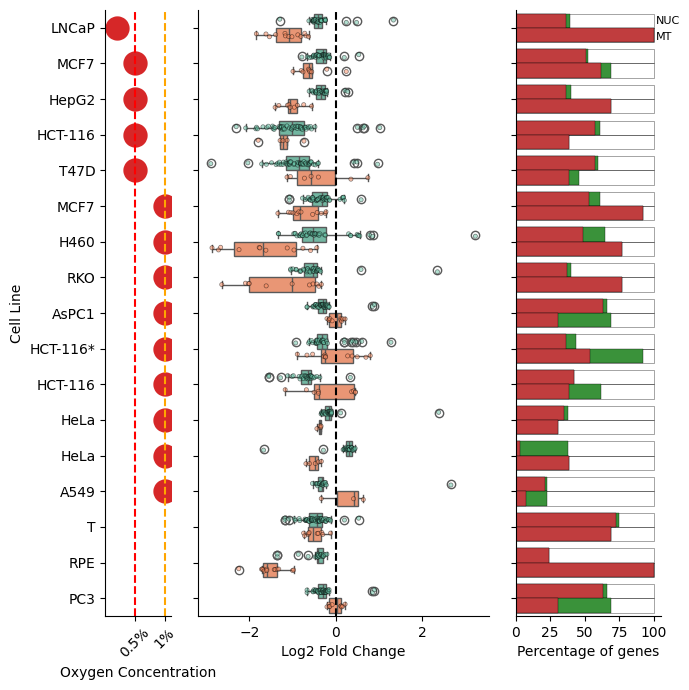

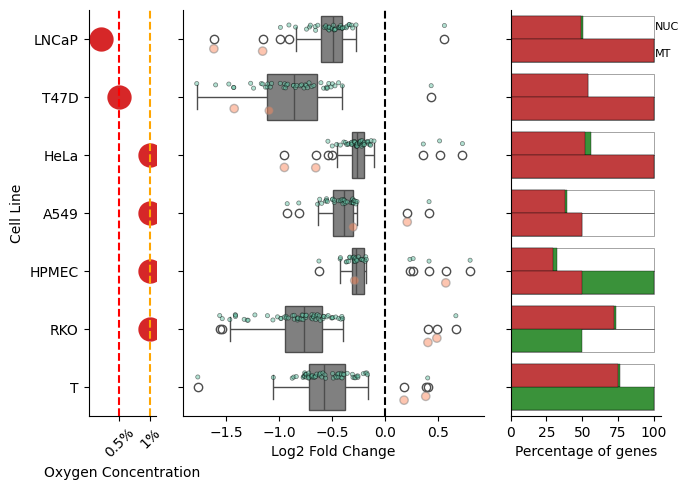

In [46]:
reload(utils)
# Only 1% hypoxia datasets
results_df_mito = results_df[results_df['Complex'].notna()]
results_df_mito = results_df_mito.sort_values(by = ['oxphos_coordination', 'log2FoldChange'], ascending = True)
results_df_mito = results_df_mito[results_df_mito['padj'] < 0.1]

reload(utils)
utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'oxphos_by_cell_line_assigned_all', strip_alpha=.5, kind = 'box', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,7), extra_x_cat = 'Oxygen Concentration')

utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] != 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc,dataset_df_mt = dataset_df_rib_mt, save_name = 'ribosome_by_cell_line_assigned_all', strip_alpha=.5, kind = 'strip', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,5), extra_x_cat = 'Oxygen Concentration')

c:\Users\shtolz\Desktop\Hypoxia\utils.py:885: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df[dataset_df[y].isin(df[y].unique())]
c:\Users\shtolz\Desktop\Hypoxia\utils.py:885: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df[dataset_df[y].isin(df[y].unique())]


Mean up: 9.5 +- 6
Mean down: 29.5 +- 26


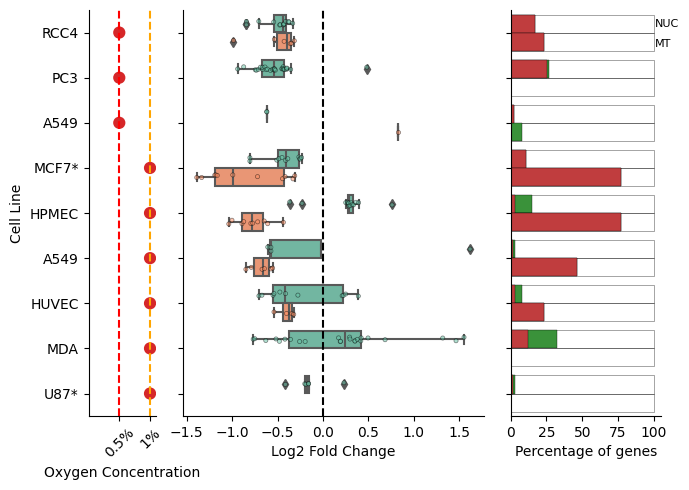

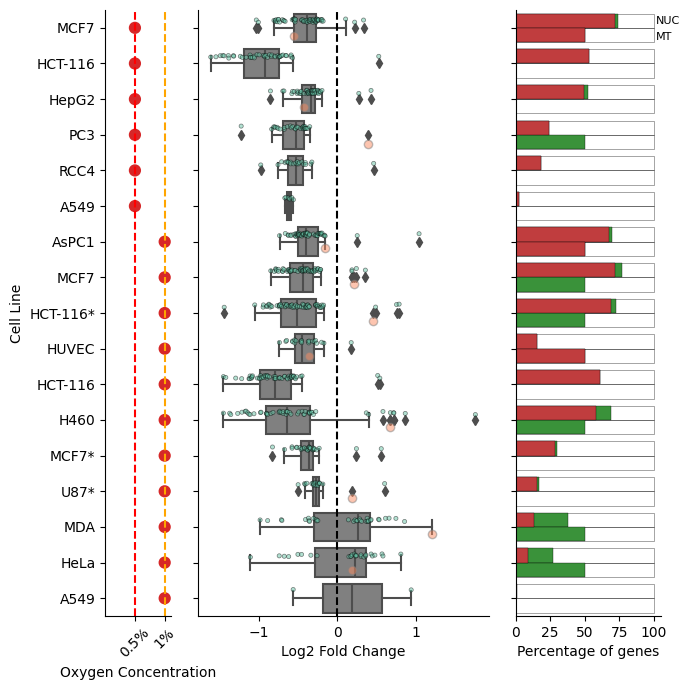

In [ ]:
reload(utils)
utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'OXPHOS') & (results_df_mito['oxphos_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_ox_nuc,dataset_df_mt = dataset_df_ox_mt, save_name = 'oxphos_by_cell_line_unassigned_all', strip_alpha=.5, kind = 'box', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,5), extra_x_cat = 'Oxygen Concentration')

utils.make_coord_plots(results_df_mito[(results_df_mito['Function'] == 'Ribosome') & (results_df_mito['ribosome_coordination'] == 'Unassigned')],dataset_df_nuc = dataset_df_rib_nuc, dataset_df_mt = dataset_df_rib_mt, save_name = 'ribosome_by_cell_line_unassigned_all', strip_alpha=.5, kind = 'strip', y = 'dataset', ylabel = 'Cell Line', x = 'log2FoldChange', title = '', dataset_sort_by = 'up_or_down', figsize = (7,7), extra_x_cat = 'Oxygen Concentration')

c:\Users\shtolz\Desktop\Hypoxia\utils.py:885: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


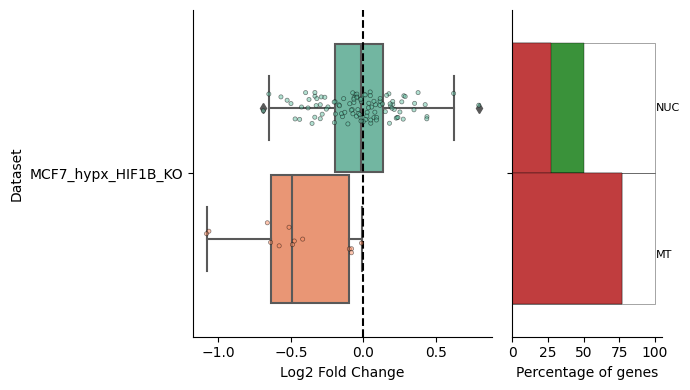

In [ ]:
# Check the mito-nuclear response in the HIF1 KO MCF7 data
# Load the hif1 KO MCF7 data
hif1_df = pd.read_csv(os.path.join(PATH, 'data', 'results', 'res_MCF7_HIF1B_KO_hypx.csv')).rename(columns = {'Unnamed: 0' : 'gene'})
hif1_df = hif1_df.merge(consts.GENELIST_DF, left_on = 'gene', right_on = 'Name',  how = 'left')
hif1_df['dataset'] = 'MCF7_hypx_HIF1B_KO'
hif1_df['cell_line'] = 'MCF7'
hif1_df.loc[hif1_df['Complex'].isin(['I', 'II', 'III', 'IV', 'V']), 'Function'] = 'OXPHOS'
hif1_df.loc[hif1_df['Complex'] == 'Ribosome', 'Function'] = 'Ribosome'
all_mcf7_results = pd.concat([results_df[results_df['dataset'] == 'MCF7_hypx_1'], results_df[results_df['dataset'] == 'MCF7_hypx_2'], results_df[results_df['dataset'] == 'MCF7_local'], hif1_df])
all_mcf7_results_ox = all_mcf7_results[all_mcf7_results['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])]
all_mcf7_results_ribo = all_mcf7_results[all_mcf7_results['Complex'] == 'Ribosome']

all_mcf7_dataset_ox = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (all_mcf7_results['Genome'] == 'NUC')].copy())
all_mcf7_dataset_ox_mt = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'].isin(['I', 'II', 'III', 'IV', 'V'])) & (all_mcf7_results['Genome'] == 'MT')].copy())
all_mcf7_dataset_rib = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'] == 'Ribosome') & (all_mcf7_results['Genome'] == 'NUC')].copy())
all_mcf7_dataset_rib_mt = make_per_dataset_df(all_mcf7_results[(all_mcf7_results['Complex'] == 'Ribosome') & (all_mcf7_results['Genome'] == 'MT')].copy())


C:\Users\shtolz\AppData\Local\Temp\ipykernel_44660\28428192.py:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset_df = dataset_df_nuc.append(dataset_df_mt)


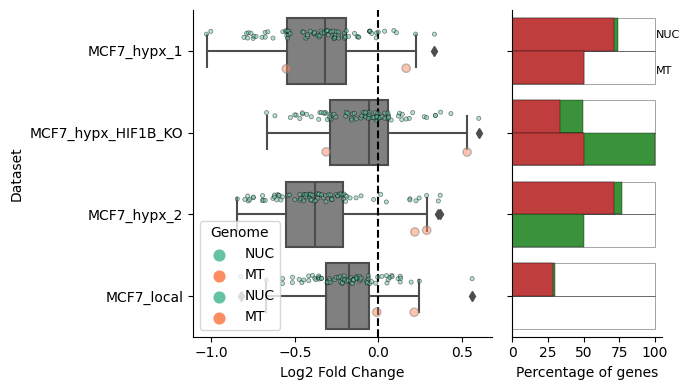

In [ ]:

# Plot the coordinated and uncoordinated datasets for Ribosome
make_coord_plots(all_mcf7_results_ribo[(all_mcf7_results_ribo['Function'] == 'Ribosome')],dataset_df_nuc = all_mcf7_dataset_rib,dataset_df_mt = all_mcf7_dataset_rib_mt, save_name = 'ribosome_mcf7', strip_alpha=.5, kind = 'x', y = 'dataset', ylabel = 'Dataset', x = 'log2FoldChange', title = '', dataset_sort_by = 'down', figsize = (7,4))

In [ ]:
mode = 'oxphos'
results_df_sign = results_df[results_df['padj'] < 22]
color = {'oxphos' : 'orange', 'ribosome' : 'purple'}
results_df_per_dataset = results_df_sign[(results_df_sign[f'{mode}_coordination'] != 'x') & (results_df_sign['Function'].isin(['OXPHOS']))].groupby(['dataset']).agg({'hindex' : 'first', 'buffa_hindex' : 'first', 'winters_hindex': 'first', 'lombardi_hindex' : 'first', 'tfam_lfc' : 'first', 'ribosome_coordination_value' : 'first', 'oxphos_coordination_value' : 'first', 'oxphos_coordination' : 'first', 'ribosome_coordination' : 'first', 'log2FoldChange': 'median', 'resid_lfc' : 'median', 'cell_line' : 'first', 'Oxygen Concentration' : 'first'}).reset_index(drop = False)
# Measure the correlation between the hindex and the ribosome coordination value
results_df_per_dataset = results_df_per_dataset.sort_values(['lombardi_hindex', 'log2FoldChange'], ascending = False)
# Add percentage symbol to Oxygen Concentration 
results_df_per_dataset['Oxygen Concentration'] = results_df_per_dataset['Oxygen Concentration'].astype(str) + '%'

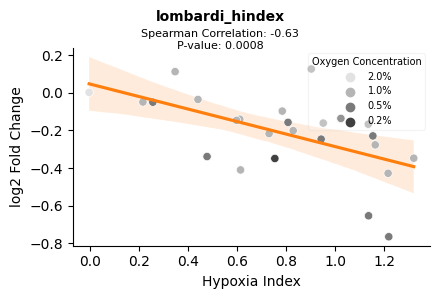

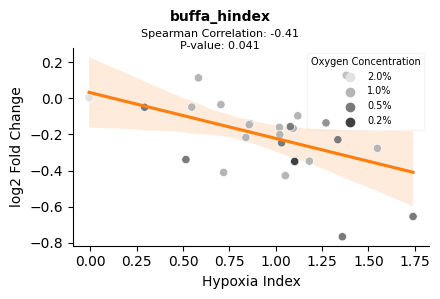

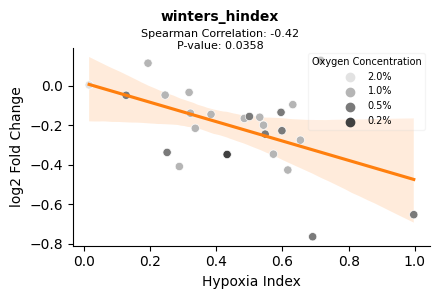

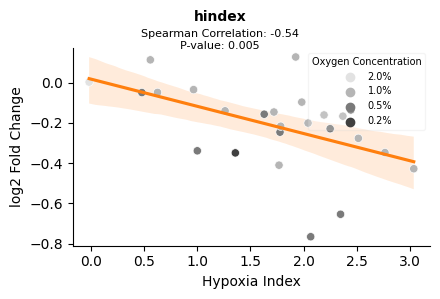

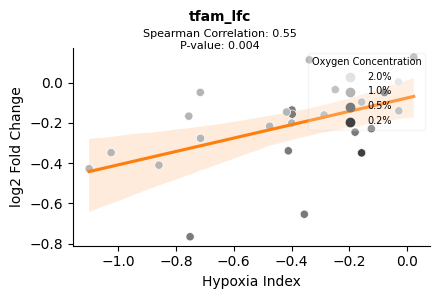

In [ ]:

for i in ['lombardi_hindex']:
     # Plot the hindex vs the mean log2FoldChange of OXPHOS genes and add pearson correlation
     #g = sns.lmplot(x = i, y = 'log2FoldChange', data = results_df_per_dataset, hue = 'Oxygen Concentration', height = 3, aspect = 1.5, scatter_kws={'alpha':0.5, 'color' : f'tab:{color[mode]}'}, line_kws={'color': f'tab:{color[mode]}'})
     g = sns.lmplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     height=3,
     aspect=1.5,
     line_kws={'color': f'tab:{color[mode]}'},  # Set the regression line color
     scatter=False  # Disable the default scatter plot within lmplot
     )

     # Add the scatter plot with hue for color distinction
     sns.scatterplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     hue='Oxygen Concentration',
     palette = 'Greys',
     hue_order = ['2.0%', '1.0%', '0.5%', '0.2%']
     )
     g.set_axis_labels('Hypoxia Index', 'log2 Fold Change')
     # Calculate pearson correlation
     pearson = stats.spearmanr(results_df_per_dataset[i], results_df_per_dataset['log2FoldChange'])
     # Add pearson correlation to plot
     g.fig.text(0.5, 0.85, 'Spearman Correlation: ' + str(round(pearson[0], 2)) + '\nP-value: ' + str(round(pearson[1], 4)), fontsize = 8, horizontalalignment = 'center')
     # Add title
     plt.suptitle(i, fontsize = 10, fontweight = 'bold')
     # Move ittle out of plot
     plt.subplots_adjust(top=0.85)
     # Make  the legend more readable
     plt.legend(title = 'Oxygen Concentration', title_fontsize = 7, fontsize = 7, loc = 'upper right', framealpha = .2)
     # Despine
     sns.despine()
     plt.tight_layout()
     # Save figure
     plt.savefig(os.path.join(PATH, 'figures', f'hindex_vs_log2foldchange_{i}_{mode}.svg'), bbox_inches = 'tight')


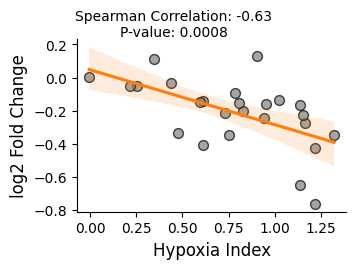

In [ ]:
# In this code block, we generate the correlation plot for the embo conference poster
i = 'lombardi_hindex'
# Plot the hindex vs the mean log2FoldChange of OXPHOS genes and add pearson correlation
#g = sns.lmplot(x = i, y = 'log2FoldChange', data = results_df_per_dataset, hue = 'Oxygen Concentration', height = 3, aspect = 1.5, scatter_kws={'alpha':0.5, 'color' : f'tab:{color[mode]}'}, line_kws={'color': f'tab:{color[mode]}'})
g = sns.lmplot(
x=i,
y='log2FoldChange',
data=results_df_per_dataset,
height=2.5,
aspect=1.5,
line_kws={'color': f'tab:{color[mode]}'},  # Set the regression line color
scatter=True,  # Disable the default scatter plot within lmplot,
scatter_kws={'s': 50, 'alpha': 0.7, 'color' : f'tab:grey', 'edgecolor' : 'black'}
)


g.set_axis_labels('Hypoxia Index', 'log2 Fold Change', fontsize = 12)
# Calculate pearson correlation
pearson = stats.spearmanr(results_df_per_dataset[i], results_df_per_dataset['log2FoldChange'])
# Add pearson correlation to plot
g.fig.text(0.5, 0.95, 'Spearman Correlation: ' + str(round(pearson[0], 2)) + '\nP-value: ' + str(round(pearson[1], 4)), fontsize = 10, horizontalalignment = 'center')
# Move ittle out of plot
plt.subplots_adjust(top=0.85)

# Despine
sns.despine()
plt.tight_layout()
# Save figure
plt.savefig(os.path.join(PATH, 'figures', f'lombardi_index_vs_oxphos_lfc_for_embo.svg'), bbox_inches = 'tight')


In [ ]:
mode = 'ribosome'

results_df_per_dataset = results_df[(results_df['oxphos_coordination'] != 'x') & (results_df['Function'] == 'Ribosome')].groupby(['dataset']).agg({'hindex' : 'first', 'buffa_hindex' : 'first', 'winters_hindex': 'first', 'lombardi_hindex' : 'first', 'tfam_lfc': 'first','ribosome_coordination_value' : 'first', 'oxphos_coordination_value' : 'first', 'oxphos_coordination' : 'first', 'ribosome_coordination' : 'first', 'log2FoldChange': 'median', 'resid_lfc' :'median', 'cell_line' : 'first', 'Oxygen Concentration' : 'first'}).reset_index(drop = False)
# Measure the correlation between the hindex and the ribosome coordination value
results_df_per_dataset = results_df_per_dataset.sort_values(['buffa_hindex', 'log2FoldChange'], ascending = False)
results_df_per_dataset['Oxygen Concentration'] = results_df_per_dataset['Oxygen Concentration'].astype(str) + '%'

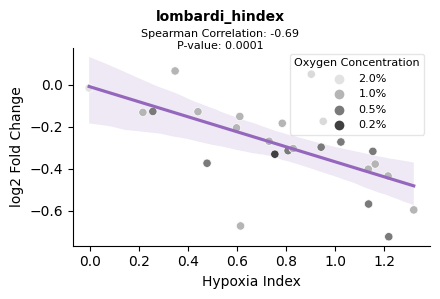

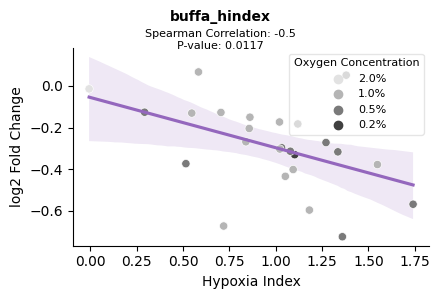

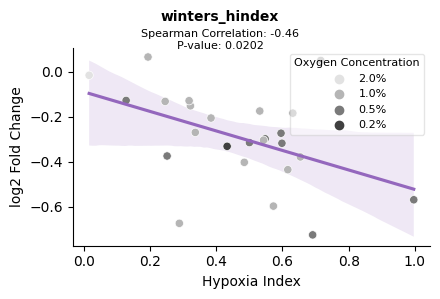

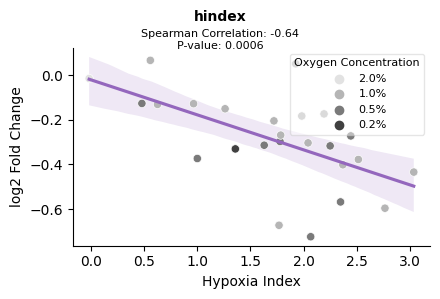

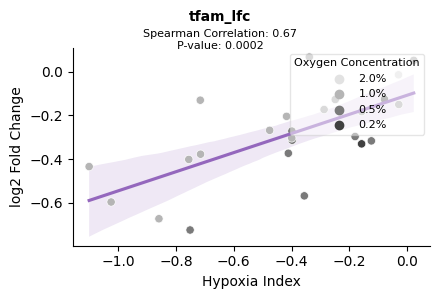

In [ ]:

for i in ['lombardi_hindex']:
     # Plot the hindex vs the mean log2FoldChange of OXPHOS genes and add pearson correlation
     #g = sns.lmplot(x = i, y = 'log2FoldChange', data = results_df_per_dataset, hue = 'Oxygen Concentration', height = 3, aspect = 1.5, scatter_kws={'alpha':0.5, 'color' : f'tab:{color[mode]}'}, line_kws={'color': f'tab:{color[mode]}'})
     g = sns.lmplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     height=3,
     aspect=1.5,
     line_kws={'color': f'tab:{color[mode]}'},  # Set the regression line color
     scatter=False  # Disable the default scatter plot within lmplot
     )

     # Add the scatter plot with hue for color distinction
     sns.scatterplot(
     x=i,
     y='log2FoldChange',
     data=results_df_per_dataset,
     hue='Oxygen Concentration',
     hue_order = ['2.0%', '1.0%', '0.5%', '0.2%'],
     palette = 'Greys'
     )
     g.set_axis_labels('Hypoxia Index', 'log2 Fold Change')
     # Calculate pearson correlation
     pearson = stats.spearmanr(results_df_per_dataset[i], results_df_per_dataset['log2FoldChange'])
     # Add pearson correlation to plot
     g.fig.text(0.5, 0.85, 'Spearman Correlation: ' + str(round(pearson[0], 2)) + '\nP-value: ' + str(round(pearson[1], 4)), fontsize = 8, horizontalalignment = 'center')
     # Add title
     plt.suptitle(i, fontsize = 10, fontweight = 'bold')
     # Move ittle out of plot
     plt.subplots_adjust(top=0.85)
     # Make  the legend more readable
     plt.legend(title = 'Oxygen Concentration', title_fontsize = 8, fontsize = 8, loc = 'upper right', framealpha = 0.5)
     # Despine
     sns.despine()
     plt.tight_layout()
     # Save figure
     plt.savefig(os.path.join(PATH, 'figures', f'hindex_vs_log2foldchange_{i}_{mode}.svg'), bbox_inches = 'tight')

